## Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
2020-03-23 <br>
[참고]https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize <br>

----------------------------------------------------------------------
### Zestimate:
“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today),

### Objective:
Building a model to improve the Zestimate residual error.
> Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. <br>
$logerror=log(Zestimate)−log(SalePrice)$

----------------------------------------------------------------------
### what I learned
> 1) NAN데이터의 수를 확일 할 때는 barh 그래프 활용.

> 2) 위도,경도 데이터를 jointplot으로 그려보면 지도모양 그릴 수있음. 
* sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)

> 3) 평균값으로 NA값을 대체 
* mean_values=train_df.mean(axis=0) <br>
    train_df_new=train_df.fillna(mean_values, inplace=True)

> 4) 각 변수와 타겟변수(logerror) 와의 상관관계 확인 (barh시각화)

> 5) 각 컬럼의 유니크한 값의 개수를 for문 활용하여 나타내기<br>
* for col in corr_zero_cols: <br>
    print(col, len(train_df_new[col].unique()))

> 6) np.argsort[::-1]으로 큰수부터 인덱스값 나열
* 원하는 변수만 가져오기 위해 인덱스값 설정
    
> 7) bar 플롯에서 가운데 선으로 표준편차 나타내기
* plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
    
> 8) ensemble.ExtraTreesRegressor 모델

In [82]:
# warning 무시
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
#pd.options.display.max_columns = 999

In [8]:
train_df = pd.read_csv("./data/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [9]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


**Logerror:** <br>

타겟 변수가 "logerror" 이므로, 먼저 살펴보자
* 양 끝에 outlier가 있는것으로 보임. outlier를 제거하고 히스토그램으로 살펴보자.

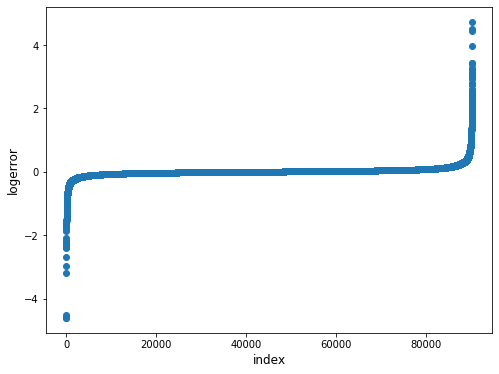

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [19]:
train_df.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

/data1/suhyuncho/.conda/envs/suhyun3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/data1/suhyuncho/.conda/envs/suhyun3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


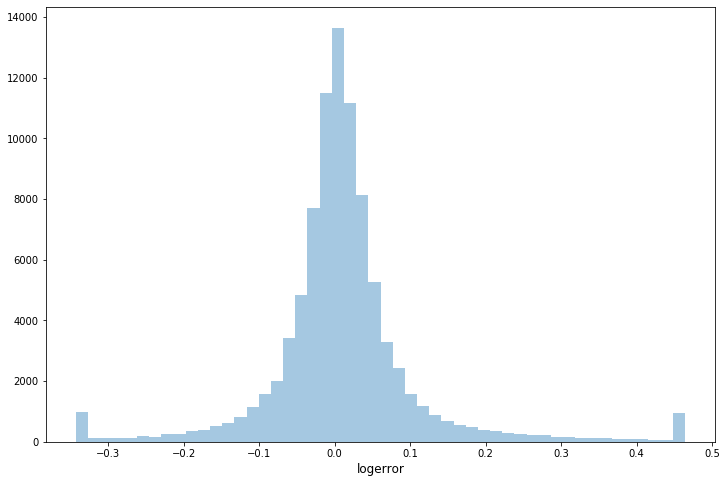

In [52]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df['logerror'].ix[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].ix[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

* outlier제거하고 난 뒤 정규분포 형태를 띔.

**Transaction Date:** <br>
각 월의 거래를 살펴보자.

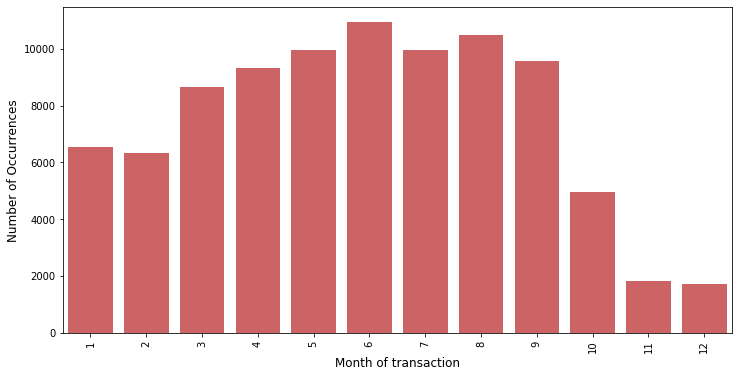

In [60]:
train_df['transaction_month']=train_df['transactiondate'].dt.month
cnt_srs=train_df['transaction_month'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

train 데이터는 2016년 10월 15일 전의 거래가 있고, 거기에 더해서 몇몇의 거래는 2016년 10월 15일 이후에 있다. <br>
그래서 지난 3개월은 바차트가 짧음.

**Parcel Id:** <br>
대부분의 parcel id들은 데이터셋에 한번만 나타난다.

In [64]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

**Properties 2016:** 데이터 살펴보기


In [72]:
prop_df = pd.read_csv("./data/properties_2016.csv")
prop_df.shape

/data1/suhyuncho/.conda/envs/suhyun3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

In [73]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


NAN값이 상당히 많은데 한번 살펴보자.

In [111]:
missing_df.head()

,column_name,missing_count
35,rawcensustractandblock,11437
25,longitude,11437
24,latitude,11437
37,regionidcounty,11437
17,fips,11437


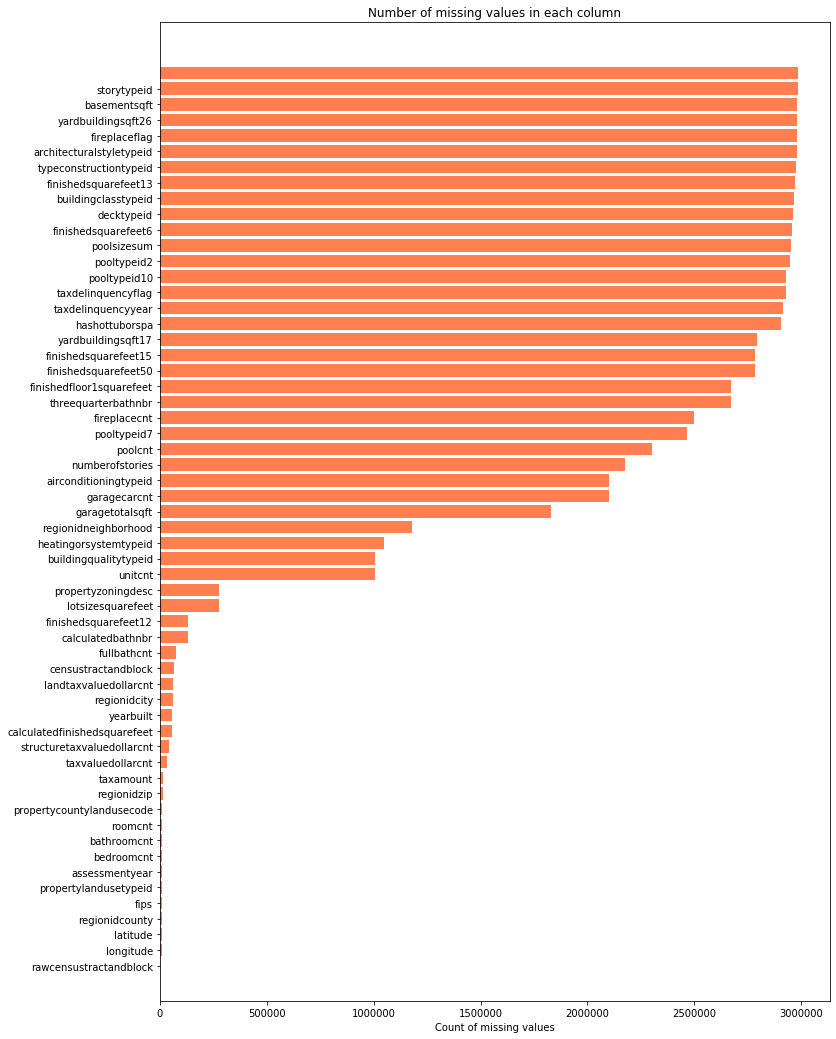

In [109]:
missing_df=prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns= ['column_name', 'missing_count']
missing_df=missing_df.ix[missing_df['missing_count']>0]
missing_df=missing_df.sort_values(by='missing_count')

ind=np.arange(missing_df.shape[0])
width=0.9
fig,ax=plt.subplots(figsize=(12,18))
rects=ax.barh(missing_df.index.sort_values(), missing_df.missing_count.values,color='coral')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

**위도와 경도 변수를 살펴보자.**

<Figure size 864x864 with 0 Axes>

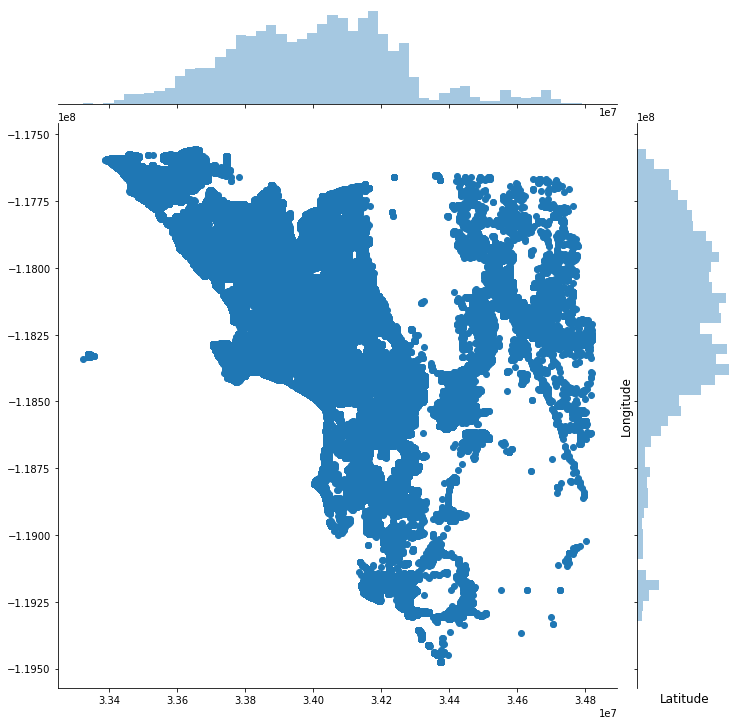

In [113]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

우리는 (Los Angeles, Orange and Ventura, California) 세 나라의 real estate정보를 갖고 있다. <br>
train데이터에는 90,811 행이 잇고 properties파일에는  2,985,217 행이 있다. <br>
그러므로 두개의 파일을 merge해서 살펴보자.

In [114]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


**변수들의 데이터 타입을 확인**

In [117]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


* 대부분 데이터는 float형태이고 object형태도 몇몇 있다.

In [118]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


* 새로합친 데이터의 null값들을 확인

In [126]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.ix[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524



* 네개의 컬럼은 99.9%가 결측치다.

**Univariate Analysis(일변량 분석):** <br>
변수가 굉장히 많으므로 float변수를 먼저 살펴보고 타겟 변수와의 상관관계를 살펴보자.

In [178]:
# 상관관계 상관계수를 구하기 위해서 결측치를 평균값으로 채운다.
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values, inplace=True)

In [181]:
train_df_new = train_df.fillna(mean_values)

In [151]:
####### for, if 문 나눠서 쓸 경우
# for col in train_df_new.columns:
#     if col not in ['logerror']:
#         if train_df_new[col].dtype=='float64':
#             print(col)

In [183]:
# 컬럼이 logerror가 아니고, 데이터타입이 float64인경우
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels=[]
values=[]
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df= pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df=corr_df.sort_values(by='corr_values')
corr_df.head()

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
33,regionidcounty,-0.009844
6,buildingqualitytypeid,-0.006648
41,yardbuildingsqft17,-0.006643


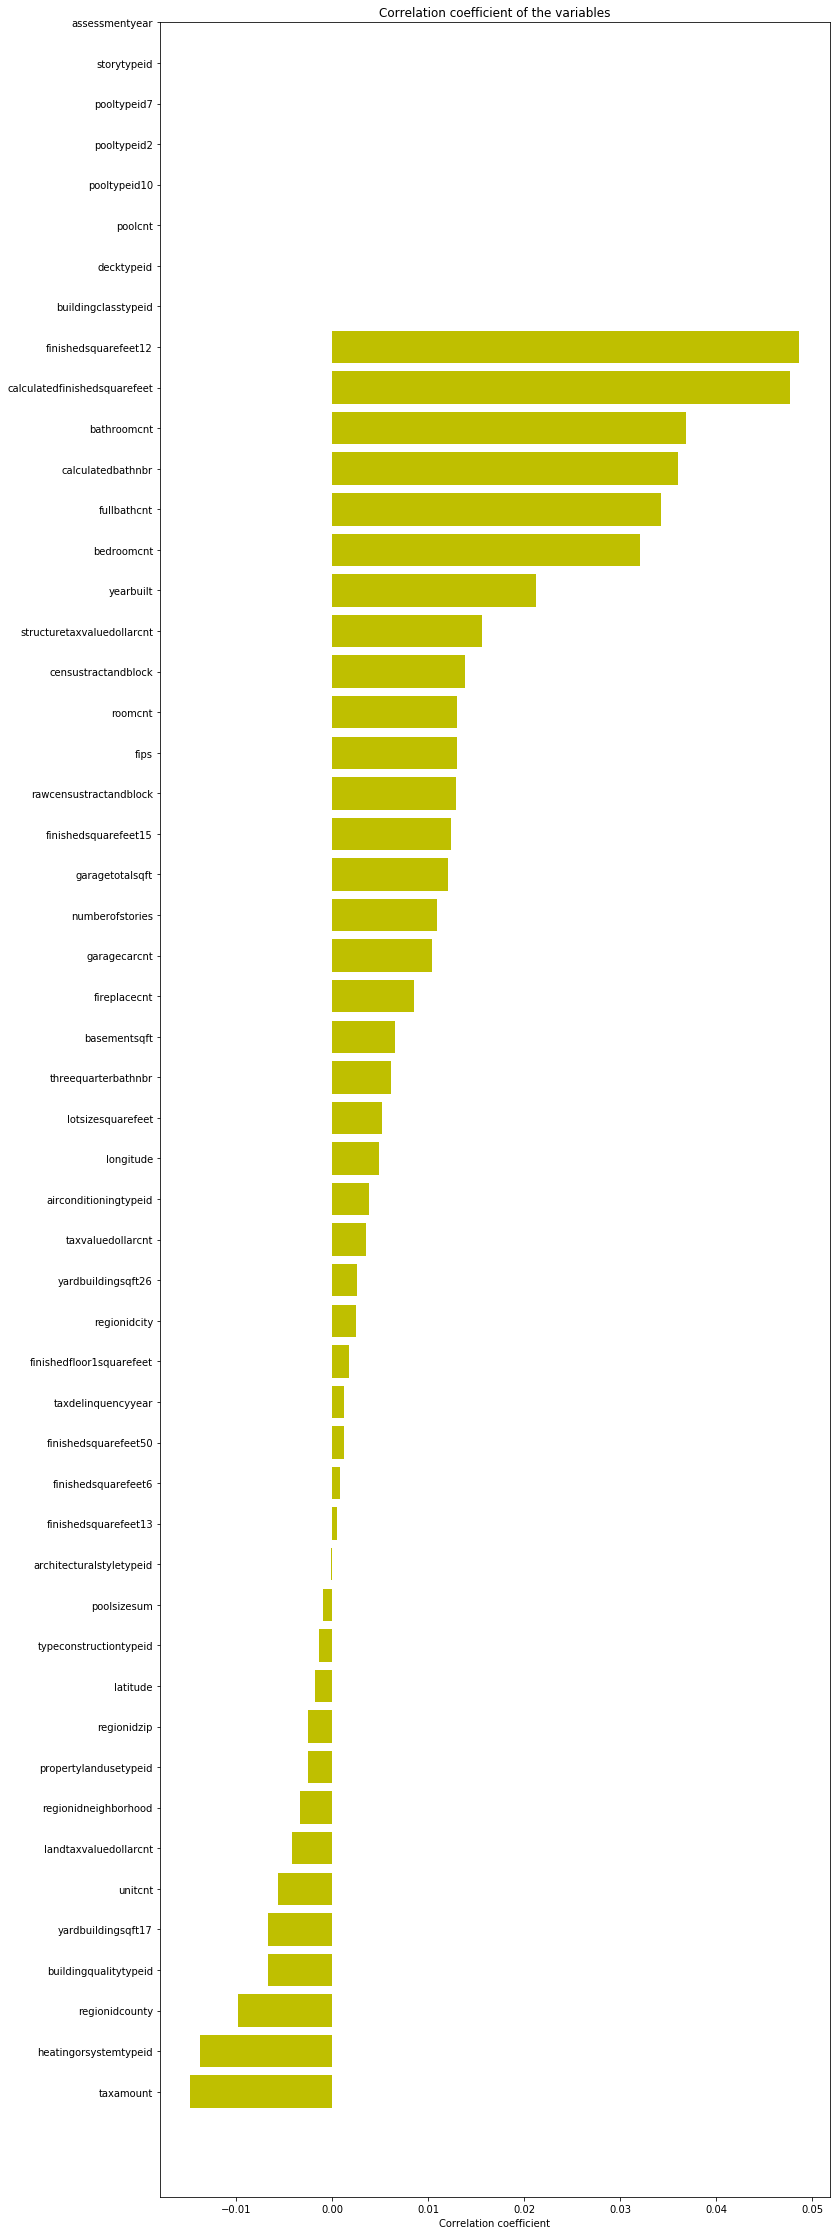

In [197]:
ind=np.arange(len(labels))
width=0.9
fig,ax=plt.subplots(figsize=(12,40))
rects=ax.barh(ind, np.array(corr_df.corr_values.values),color='y')
ax.set_yticks(ind)   # 이거안써주면 눈금간격이 넓어서 모든 컬럼값이 보이지 않음.
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

* 타겟 변수와 다른 변수와의 상관관계는 전반적으로 낮은 편.<br>
* 맨 위에보면 타겟변수와 아무런 상관관계가 없는 변수들이 있다. <br>
    * 예상으로는, 하나의 유니크한 값만 있어서 상관관계가 없게 나온것으로 보인다. 


In [202]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


**상관관계가 높은 변수들간의 관계를 분석**

In [210]:
corr_df_sel =corr_df.query('corr_values >0.02 or corr_values<-0.01')
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


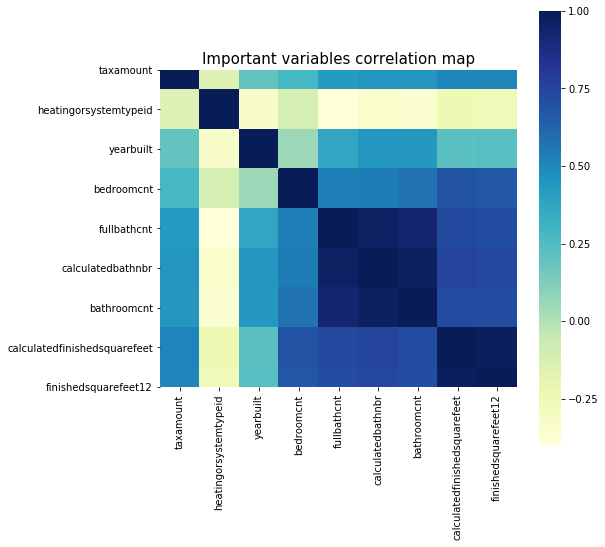

In [217]:
cols_to_use=corr_df_sel.col_labels.tolist()

temp_df=train_df[cols_to_use]
corrmat=temp_df.corr(method='spearman')

f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(corrmat,vmax=1., square=True,cmap="YlGnBu")
plt.title("Important variables correlation map",fontsize=15)
plt.show()

In [219]:
corrmat

,taxamount,heatingorsystemtypeid,yearbuilt,bedroomcnt,fullbathcnt,calculatedbathnbr,bathroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12
taxamount,1.000000,-0.146225,0.201860,0.285593,0.427380,0.451628,0.443492,0.512639,0.509939
heatingorsystemtypeid,-0.146225,1.000000,-0.330752,-0.116412,-0.402105,-0.347304,-0.354261,-0.245563,-0.256560
yearbuilt,0.201860,-0.330752,1.000000,0.055093,0.376464,0.442686,0.438188,0.225063,0.236199
bedroomcnt,0.285593,-0.116412,0.055093,1.000000,0.533048,0.543549,0.582353,0.688113,0.672202
fullbathcnt,0.427380,-0.402105,0.376464,0.533048,1.000000,0.964029,0.926949,0.735106,0.715418
calculatedbathnbr,0.451628,-0.347304,0.442686,0.543549,0.964029,1.000000,0.969927,0.758943,0.741720
bathroomcnt,0.443492,-0.354261,0.438188,0.582353,0.926949,0.969927,1.000000,0.729014,0.715917
calculatedfinishedsquarefeet,0.512639,-0.245563,0.225063,0.688113,0.735106,0.758943,0.729014,1.000000,0.981638
finishedsquarefeet12,0.509939,-0.256560,0.236199,0.672202,0.715418,0.741720,0.715917,0.981638,1.000000


**Finished SquareFeet 12:** <br>
finished square feet 12 변수가 log error와 다른지 확인.

<Figure size 864x864 with 0 Axes>

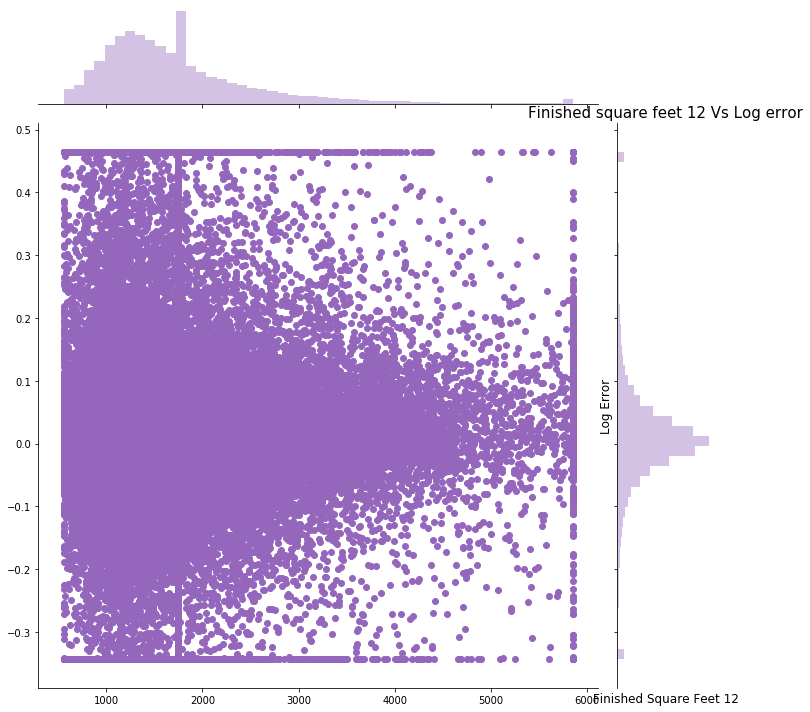

In [220]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

* finishedsquarefeet12 이값이 커질수록 logerror값의 범위가 좁아지는 형태를 띔.

**Calculated finished square feet:**

<Figure size 864x864 with 0 Axes>

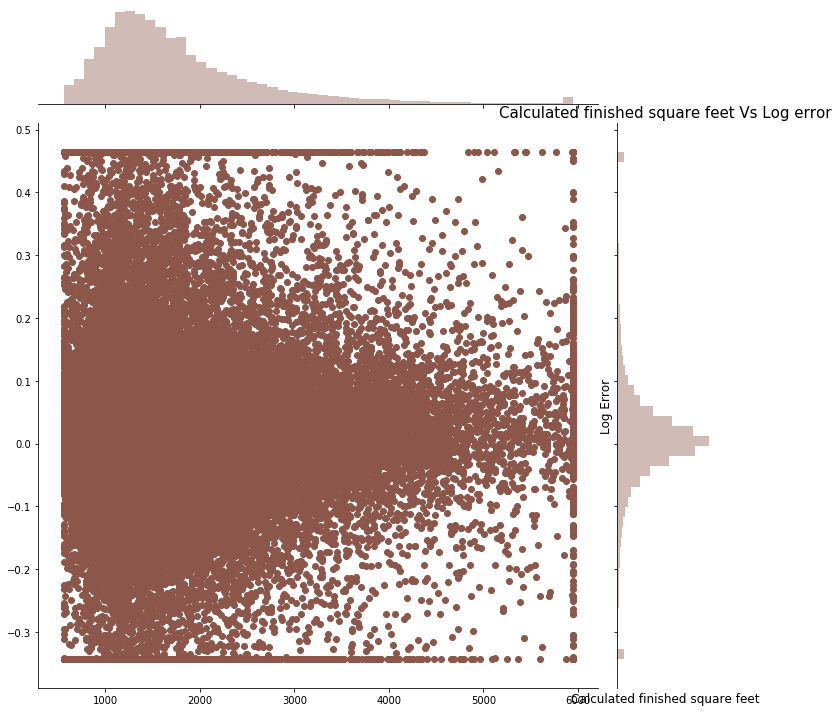

In [237]:
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

* 위와 동일한 분포 형태를 보인다. 
    * 또한 Calculated finished square feet과 finishedsquarefeet12 변수간의 상관계수도 0.98로 상당히 높음.

**Bathroom Count:**

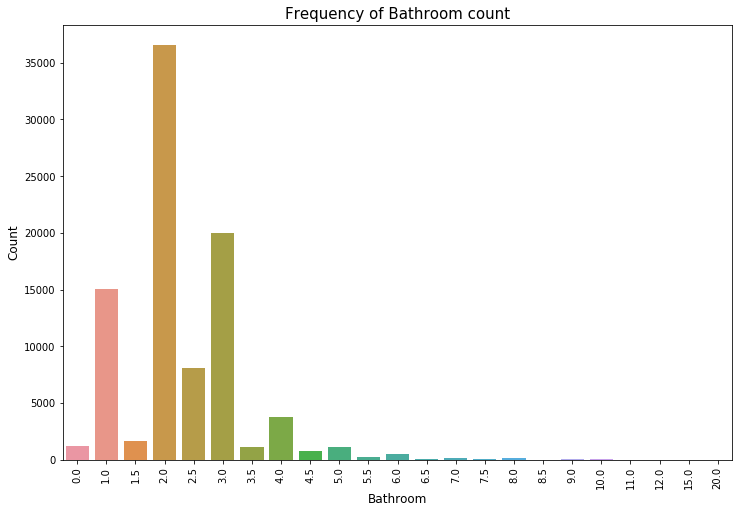

In [238]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

bathromm 수에 따라 logerror가 어떻게 변하는지 확인.

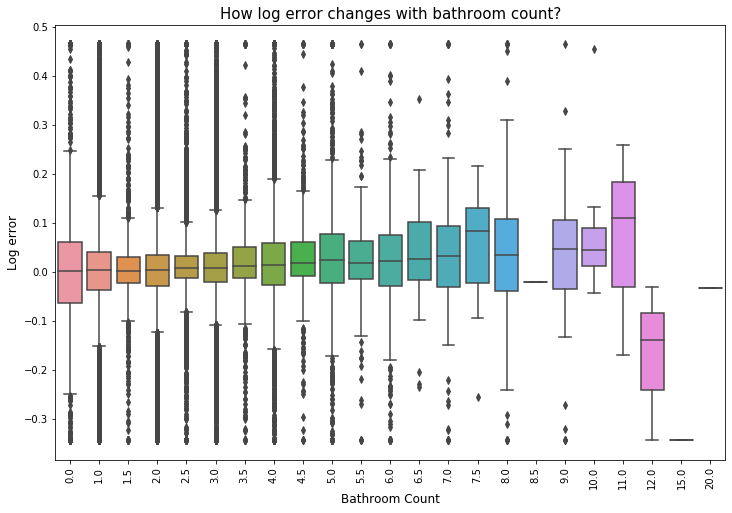

In [239]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()


**Bedroom count:**

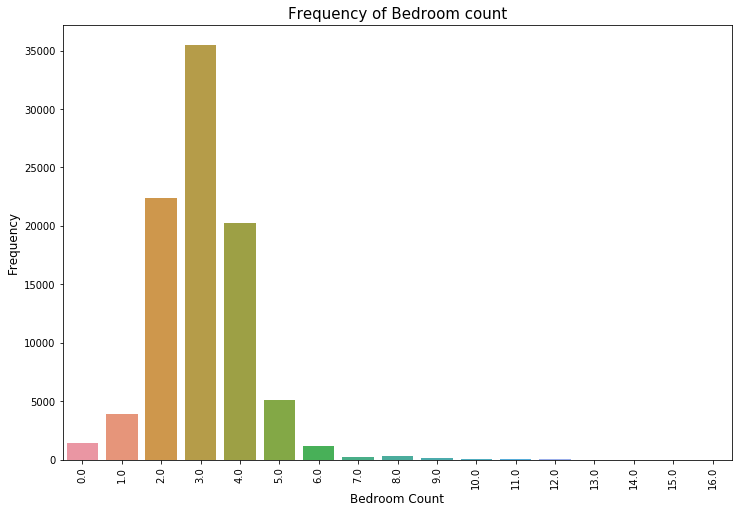

In [240]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

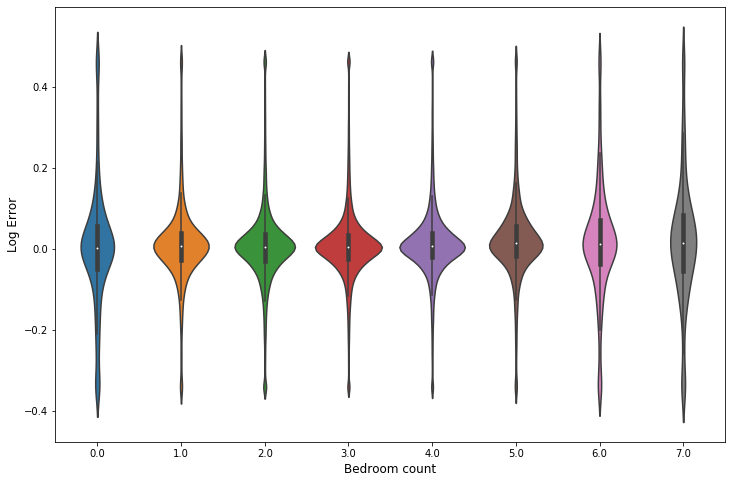

In [241]:
train_df['bedroomcnt'].ix[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

<Figure size 864x864 with 0 Axes>

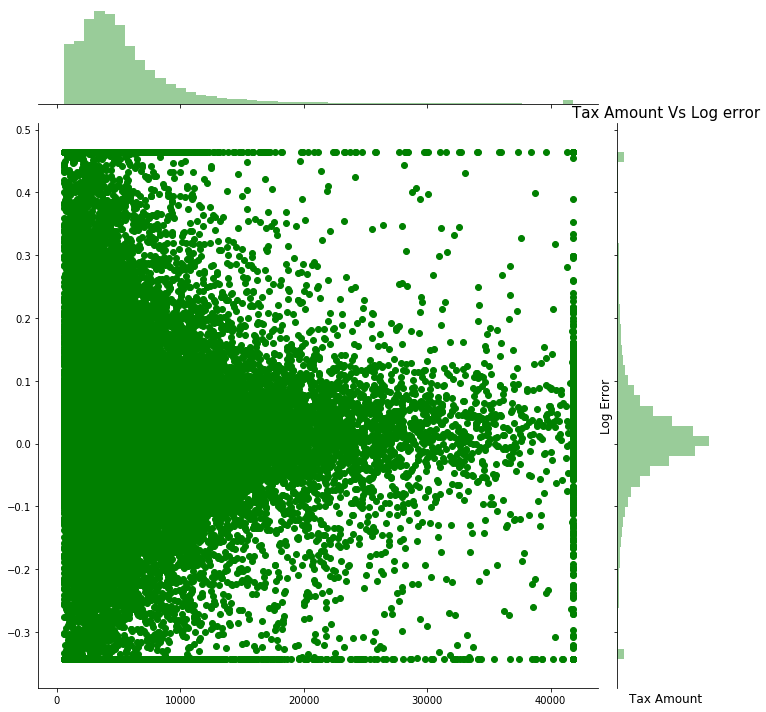

In [245]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:** <br>
yearbuilt변수와 logerror가 어떻게 다른지 확인.

<Figure size 864x864 with 0 Axes>

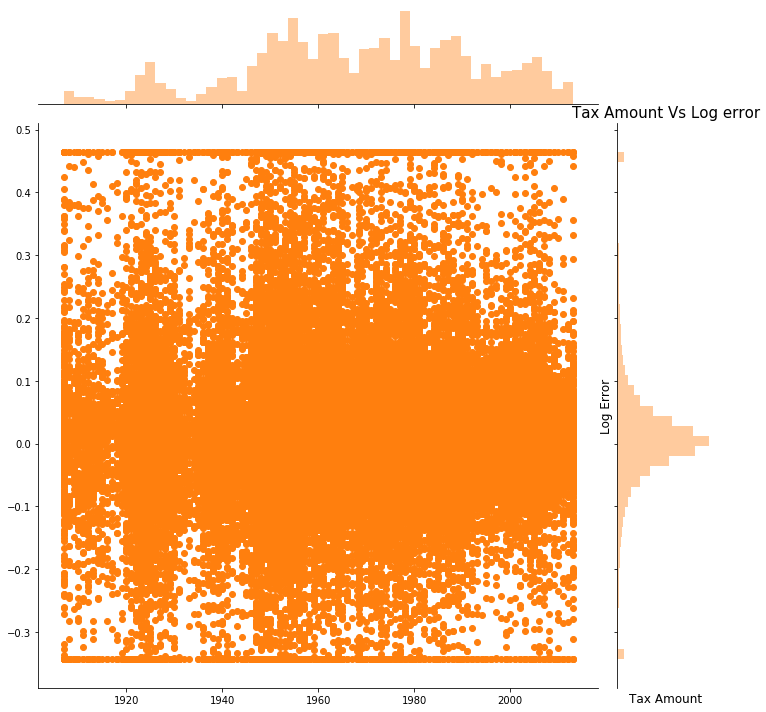

In [273]:
col = "yearbuilt"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['yearbuilt'].values, y=train_df['logerror'].values, size=10, color=color[1])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

### Extra Trees model활용
Extra Trees model을 이용해서 비선형모델을 만들어보자. 중요 변수를 얻기 위함.

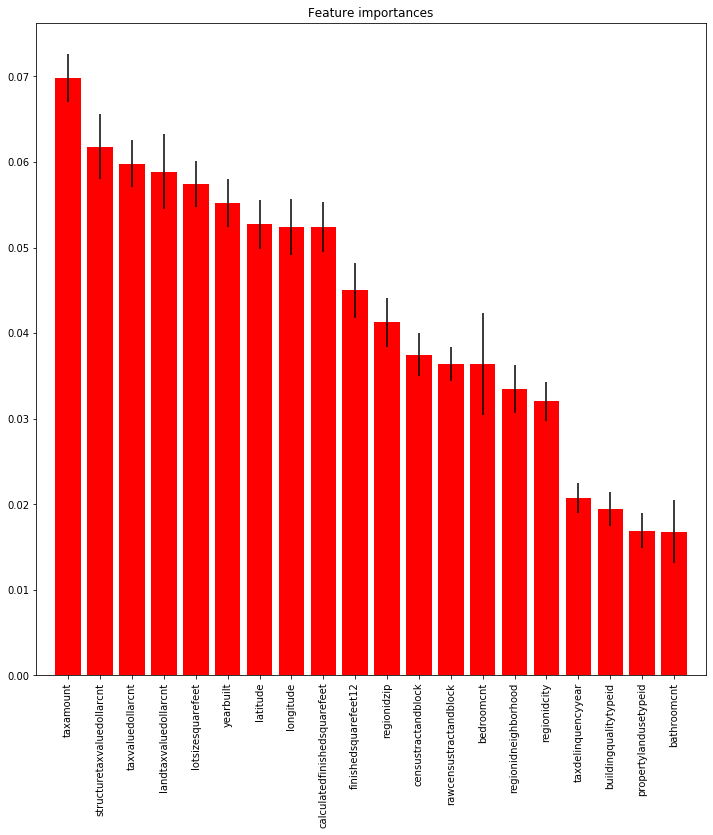

In [311]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]   # np.argsort[::-1]으로 큰수부터 인덱스값 나열

plt.figure(figsize=(12,12))
plt.title("Feature importances")
# bar 플롯에서 가운데 선으로 표준편차 나타내기.
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()